**Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score,confusion_matrix

**Dataset**

In [ ]:
df=pd.read_csv('/content/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


**Data Analysis**

In [ ]:
df.shape

(7613, 5)

In [ ]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

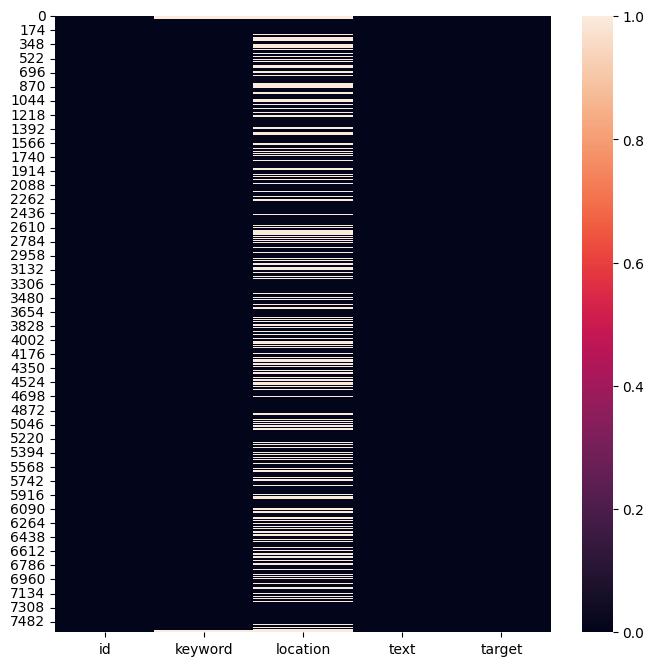

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(df.isnull())
plt.show()

<ipython-input-6-4e7efe3cfbec>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target',data=train_df,palette='deep')


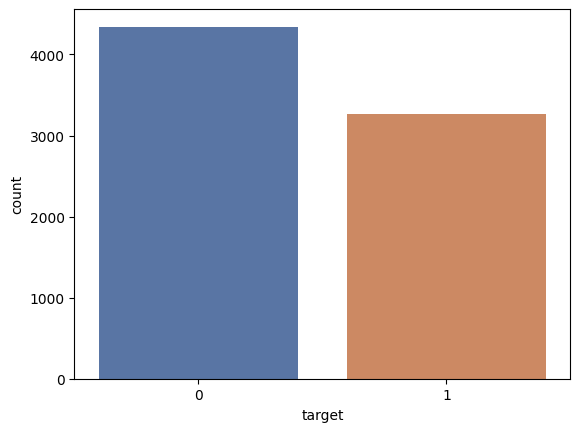

In [ ]:
sns.countplot(x='target',data=df,palette='deep')
plt.show()

**Splitting Data for Training and Testing**

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(df['text'],df['target'],stratify=df['target'],test_size=0.15,random_state=40)

In [ ]:
print(x_train.shape,x_test.shape)

(6471,) (1142,)


**Model Building and Training**

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name,num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

In [ ]:
x_train=list(x_train)
y_train=y_train.to_numpy()

In [ ]:
max_length = 50
train_encodings = tokenizer(x_train, truncation=True, padding=True, max_length=max_length,return_tensors='tf')

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).shuffle(100).batch(32)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model.fit(train_dataset, epochs=15)

Epoch 1/15
203/203 [==============================] - 63s 312ms/step - loss: 0.2829 - accuracy: 0.8928
Epoch 2/15
203/203 [==============================] - 65s 322ms/step - loss: 0.2111 - accuracy: 0.9247
Epoch 3/15
203/203 [==============================] - 67s 328ms/step - loss: 0.1609 - accuracy: 0.9431
Epoch 4/15
203/203 [==============================] - 67s 330ms/step - loss: 0.1155 - accuracy: 0.9586
Epoch 5/15
203/203 [==============================] - 67s 329ms/step - loss: 0.0979 - accuracy: 0.9620
Epoch 6/15
203/203 [==============================] - 67s 329ms/step - loss: 0.0811 - accuracy: 0.9686
Epoch 7/15
203/203 [==============================] - 67s 329ms/step - loss: 0.0580 - accuracy: 0.9756
Epoch 8/15
203/203 [==============================] - 67s 329ms/step - loss: 0.0479 - accuracy: 0.9785
Epoch 9/15
203/203 [==============================] - 67s 329ms/step - loss: 0.0541 - accuracy: 0.9756
Epoch 10/15
203/203 [==============================] - 67s 329ms/step - l

**Test Data**

In [ ]:
x_test=list(x_test)
test_encodings = tokenizer(x_test, truncation=True, padding=True, max_length=max_length,return_tensors='tf')

**Prediction**

In [ ]:
logits = model.predict(test_encodings)[0]
probabilities = tf.nn.softmax(logits, axis=-1)
predicted_label = tf.argmax(probabilities, axis=-1).numpy()

36/36 [==============================] - 13s 108ms/step


In [ ]:
print(accuracy_score(y_test,predicted_label))

0.8099824868651488


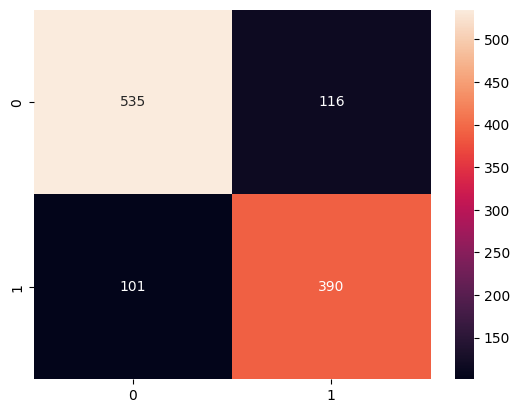

In [ ]:
sns.heatmap(confusion_matrix(y_test,predicted_label),annot=True,fmt='d')
plt.show()